In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score,roc_auc_score
import optuna
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [2]:
test = pd.read_csv('test.csv')
# sample = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
comb=pd.concat([train,test])

In [5]:
comb.isna().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

In [6]:
Expenses_columns = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
comb.loc[:,Expenses_columns]=comb.apply(lambda x: 0 if x.CryoSleep == True else x,axis =1)

In [7]:
comb["in"] = comb["Spa"] + comb["VRDeck"] + comb["RoomService"]

comb["out"] =  comb['FoodCourt'] + comb['ShoppingMall'] 


In [8]:
comb['Expenses'] = comb.loc[:,Expenses_columns].sum(axis=1)

In [9]:
comb.loc[:,['CryoSleep']]=comb.apply(lambda x: True if x.Expenses == 0 and pd.isna(x.CryoSleep) else x,axis =1)

In [10]:
comb.Name = comb.Name.fillna('x x')

In [11]:
comb.loc[:,['Room']] = comb.PassengerId.apply(lambda x: x[0:4] )
guide_VIP=comb.loc[:,['Room','VIP']].dropna().drop_duplicates('Room')
guide_Cabin=comb.loc[:,['Room','Cabin']].dropna().drop_duplicates('Room')
guide_HomePlanet=comb.loc[:,['Room','HomePlanet']].dropna().drop_duplicates('Room')
guide_Destination=comb.loc[:,['Room','Destination']].dropna().drop_duplicates('Room')
comb=pd.merge(comb,guide_Cabin,how="left",on='Room',suffixes=('','_y'))
comb=pd.merge(comb,guide_VIP,how="left",on='Room',suffixes=('','_y'))
comb=pd.merge(comb,guide_HomePlanet,how="left",on='Room',suffixes=('','_y'))
comb=pd.merge(comb,guide_Destination,how="left",on='Room',suffixes=('','_y'))

In [12]:
comb.loc[:,['VIP']]=comb.apply(lambda x: x.VIP_y if pd.isna(x.VIP) else x,axis=1)
comb.loc[:,['Cabin']]=comb.apply(lambda x:  x.Cabin_y if pd.isna(x.Cabin) else x,axis=1)
comb.loc[:,['HomePlanet']]=comb.apply(lambda x:  x.HomePlanet_y if pd.isna(x.HomePlanet) else x,axis=1)
comb.loc[:,['Destination']]=comb.apply(lambda x:  x.Destination_y if pd.isna(x.Destination) else x,axis=1)

In [13]:
comb.loc[:,['Cabin_1']] = comb.Cabin.str.split("/",expand=True).iloc[:,0]
comb.loc[:,['Cabin_2']] = comb.Cabin.str.split("/",expand=True).iloc[:,1]
comb.loc[:,['Cabin_3']] = comb.Cabin.str.split("/",expand=True).iloc[:,2]

In [14]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses','Age',"in","out"]
cat_cols = ['CryoSleep','Cabin_1','Cabin_3','VIP','HomePlanet','Destination']
transported=['Transported']
comb = comb[num_cols+cat_cols+transported].copy()

In [15]:
nums=list(comb.select_dtypes(include="number"))

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
imp_missforest = IterativeImputer(
    estimator=ExtraTreesRegressor(),
    max_iter=30
).set_output(transform="pandas")
imp_missforest.fit(comb[nums])

c:\Users\oskar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


IterativeImputer(estimator=ExtraTreesRegressor(), max_iter=30)

In [17]:
comb[nums] = imp_missforest.transform(comb[nums])

In [18]:
cat_cols = ['CryoSleep','Cabin_1','Cabin_3','VIP','HomePlanet','Destination']
cat_imp = SimpleImputer(strategy='most_frequent')
comb[cat_cols] = cat_imp.fit_transform(comb[cat_cols])
comb.Cabin_3=comb.Cabin_3.fillna("P")

In [19]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses','Age',"in","out"]
cat_cols = ['CryoSleep','Cabin_1','Cabin_3','VIP','HomePlanet','Destination']
transported=['Transported']
comb = comb[num_cols+cat_cols+transported].copy()

In [20]:
comb.CryoSleep = comb.CryoSleep.astype(int)

In [162]:
train = comb[comb['Transported'].notnull()].copy()
train.Transported =train.Transported.astype('int')
test = comb[comb['Transported'].isnull()].drop("Transported",axis=1)

In [163]:
train.head()

,ShoppingMall,FoodCourt,RoomService,Spa,VRDeck,Expenses,Age,in,out,CryoSleep,Cabin_1,Cabin_3,VIP,HomePlanet,Destination,Transported
0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0,B,P,False,Europa,TRAPPIST-1e,0
1,25.0,9.0,109.0,549.0,44.0,736.0,24.0,702.0,34.0,0,F,S,False,Earth,TRAPPIST-1e,1
2,0.0,3576.0,43.0,6715.0,49.0,10383.0,58.0,6807.0,3576.0,0,A,S,True,Europa,TRAPPIST-1e,0
3,371.0,1283.0,0.0,3329.0,193.0,5176.0,33.0,3522.0,1654.0,0,A,S,False,Europa,TRAPPIST-1e,0
4,151.0,70.0,303.0,565.0,2.0,1091.0,16.0,870.0,221.0,0,F,S,False,Earth,TRAPPIST-1e,1


In [164]:
pd.crosstab(train.VIP,train.Transported)

Transported,0,1
VIP,,
False,4192,4302
True,123,76


In [165]:
train.drop("VIP",axis=1,inplace=True)

In [166]:
nunique = pd.DataFrame(train.nunique())
nunique.style.background_gradient(cmap="turbo")

,0
ShoppingMall,1224
FoodCourt,1616
RoomService,1378
Spa,1438
VRDeck,1405
Expenses,2336
Age,169
in,2583
out,2163
CryoSleep,2


In [167]:
fig = px.pie(train, names='Transported', title='Transported Pie Chart')
fig.show()

In [168]:
cat_cols = ['CryoSleep', 'Cabin_1', 'Cabin_3','HomePlanet', 'Destination']

In [169]:
train

,ShoppingMall,FoodCourt,RoomService,Spa,VRDeck,Expenses,Age,in,out,CryoSleep,Cabin_1,Cabin_3,HomePlanet,Destination,Transported
0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0,B,P,Europa,TRAPPIST-1e,0
1,25.0,9.0,109.0,549.0,44.0,736.0,24.0,702.0,34.0,0,F,S,Earth,TRAPPIST-1e,1
2,0.0,3576.0,43.0,6715.0,49.0,10383.0,58.0,6807.0,3576.0,0,A,S,Europa,TRAPPIST-1e,0
3,371.0,1283.0,0.0,3329.0,193.0,5176.0,33.0,3522.0,1654.0,0,A,S,Europa,TRAPPIST-1e,0
4,151.0,70.0,303.0,565.0,2.0,1091.0,16.0,870.0,221.0,0,F,S,Earth,TRAPPIST-1e,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,6819.0,0.0,1643.0,74.0,8536.0,41.0,1717.0,6819.0,0,A,P,Europa,55 Cancri e,0
8689,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,1,G,S,Earth,PSO J318.5-22,0
8690,1872.0,0.0,0.0,1.0,0.0,1873.0,26.0,1.0,1872.0,0,G,S,Earth,TRAPPIST-1e,1
8691,0.0,1049.0,0.0,353.0,3235.0,4637.0,32.0,3588.0,1049.0,0,E,S,Europa,55 Cancri e,0


In [170]:
for col in cat_cols:
    print(train.groupby(col)[["Transported"]].agg(["mean","count"]))
    print("=======")

          Transported      
                 mean count
CryoSleep                  
0            0.328176  5558
1            0.814673  3135
        Transported      
               mean count
Cabin_1                  
A          0.503817   262
B          0.732412   796
C          0.680683   761
D          0.433265   487
E          0.360452   885
F          0.439519  2910
G          0.516042  2587
T          0.200000     5
        Transported      
               mean count
Cabin_3                  
P          0.451724  4350
S          0.555607  4343
           Transported      
                  mean count
HomePlanet                  
Earth         0.425079  4745
Europa        0.659880  2161
Mars          0.523223  1787
              Transported      
                     mean count
Destination                    
55 Cancri e      0.609796  1817
PSO J318.5-22    0.503731   804
TRAPPIST-1e      0.471838  6072


Cabin_drop: A,D,G,T, Hp:Mars, Dest: PSO J318.5-22,TRAPPIST-1e

In [171]:
train.groupby("Transported")[["Expenses"]].agg(["mean"])

,Expenses
,mean
Transported,
0,2004.149247
1,885.689127


In [172]:
train.groupby("Transported")[["in"]].agg(["mean"])

,in
,mean
Transported,
0,1467.702783
1,194.598952


In [173]:
train.groupby("Transported")[["out"]].agg(["mean"])

,out
,mean
Transported,
0,553.758209
1,698.449271


<Axes: xlabel='HomePlanet', ylabel='Count'>

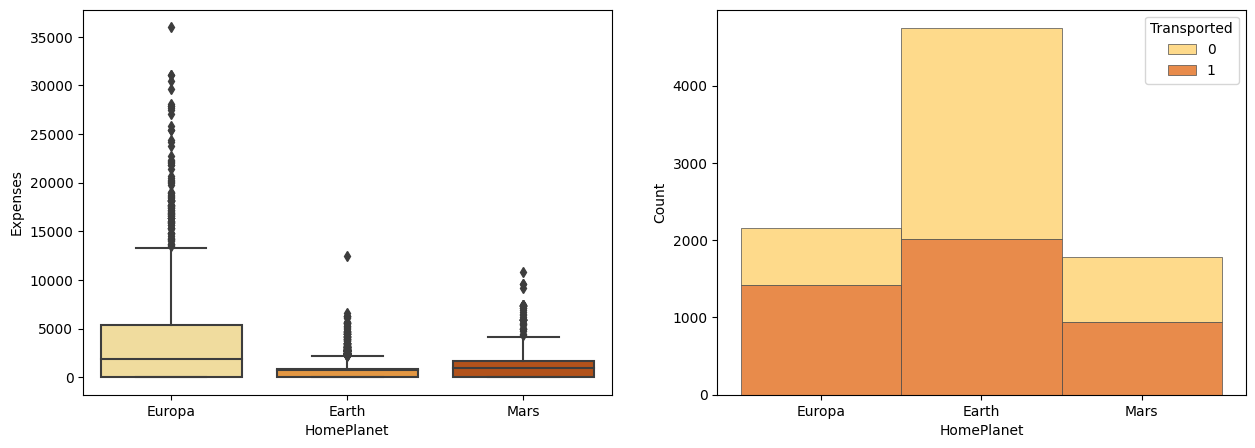

In [174]:
import seaborn as sns
f, ax = plt.subplots(1, 2, figsize = (15,5))
sns.boxplot(x = "HomePlanet", y = "Expenses", palette = "YlOrBr", data = train, ax = ax[0])
sns.histplot(train, x = "HomePlanet", hue = "Transported", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1])


<Axes: xlabel='Destination', ylabel='Count'>

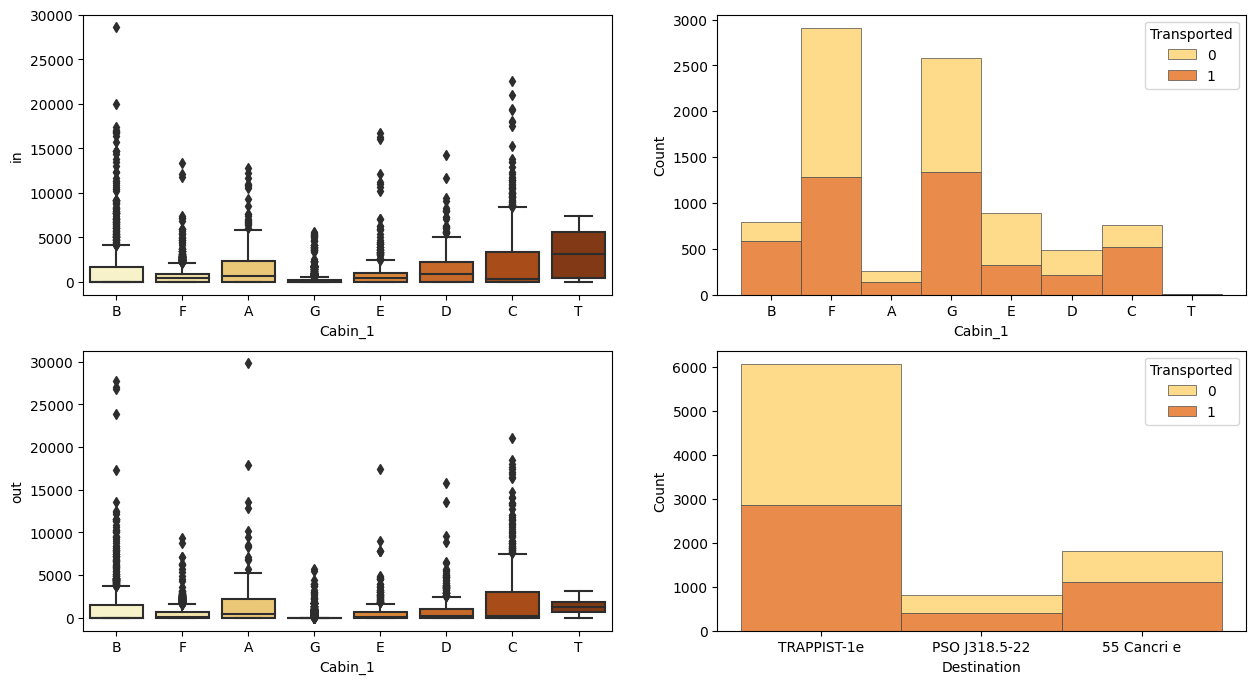

In [175]:
f, ax = plt.subplots(2, 2, figsize = (15,8))
sns.boxplot(x = "Cabin_1", y = "in", palette = "YlOrBr", data = train, ax = ax[0, 0])
sns.histplot(train, x = "Cabin_1", hue = "Transported", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[0, 1])
sns.boxplot(x = "Cabin_1", y = "out", palette = "YlOrBr", data = train, ax = ax[1, 0])
sns.histplot(train, x = "Destination", hue = "Transported", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1, 1])


In [176]:
train["c"]=((train.HomePlanet=="Europa")& (train.CryoSleep==1)).astype(int)

In [177]:
from category_encoders import OneHotEncoder
ohe = OneHotEncoder(
    cols=['Cabin_1','HomePlanet','Destination'],
    use_cat_names=True

)
ohe.fit(train)
train = ohe.transform(train)

In [178]:
train.columns

Index(['ShoppingMall', 'FoodCourt', 'RoomService', 'Spa', 'VRDeck', 'Expenses',
       'Age', 'in', 'out', 'CryoSleep', 'Cabin_1_B', 'Cabin_1_F', 'Cabin_1_A',
       'Cabin_1_G', 'Cabin_1_E', 'Cabin_1_D', 'Cabin_1_C', 'Cabin_1_T',
       'Cabin_3', 'HomePlanet_Europa', 'HomePlanet_Earth', 'HomePlanet_Mars',
       'Destination_TRAPPIST-1e', 'Destination_PSO J318.5-22',
       'Destination_55 Cancri e', 'Transported', 'c'],
      dtype='object')

In [179]:
# Cabin_drop: A,D,G,T, Hp:Mars, Dest: PSO J318.5-22,TRAPPIST-1e

In [180]:
train.drop(['Cabin_1_A','Cabin_1_D','Cabin_1_G','Cabin_1_T','HomePlanet_Mars','Destination_PSO J318.5-22','Destination_TRAPPIST-1e'],axis=1,inplace=True)

In [181]:
train.Cabin_3 = train.Cabin_3.map({"P":1,"S":2})

In [182]:
X = train.drop("Transported",axis=1)
y=train["Transported"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [235]:
from catboost import CatBoostClassifier, EShapCalcType, EFeaturesSelectionAlgorithm,Pool



train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)


    
def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(iterations=500, random_seed=0)
    summary = model.select_features(
        train_pool,
        eval_set=test_pool,
        features_for_select=list(range(train_pool.num_col())),
        num_features_to_select=8,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

adult_shap_summary = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=3)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['Spa', 'Age', 'in', 'out', 'CryoSleep', 'Cabin_3', 'HomePlanet_Europa', 'HomePlanet_Earth']


 98%|===================| 3418/3478 [00:29<00:00]          

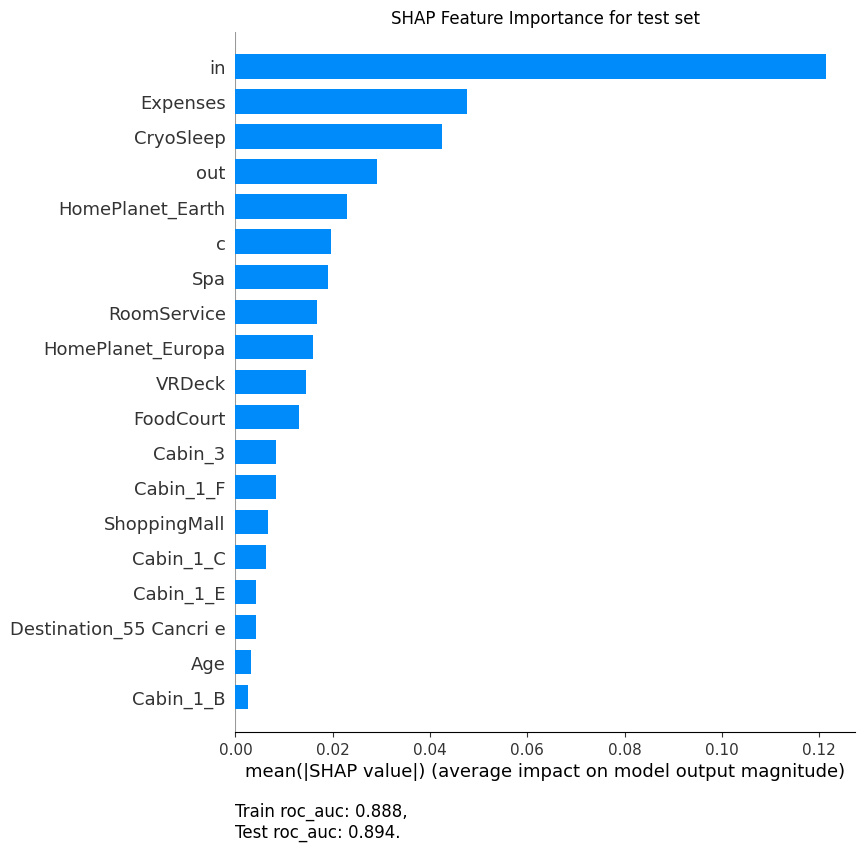

In [250]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from probatus.interpret import ShapModelInterpreter
import warnings
warnings.filterwarnings('ignore')

clf = RandomForestClassifier(n_estimators = 300, random_state=0,max_depth =5)
clf = clf.fit(X_train, y_train)
shap_interpreter = ShapModelInterpreter(clf)
feature_importance = shap_interpreter.fit_compute(X_train, X_test, y_train, y_test, approximate=False)
ax = shap_interpreter.plot('importance')

In [43]:
pd.crosstab(train.Cabin_1_B,train.Transported)

Transported,0,1
Cabin_1_B,,
0,4102,3795
1,213,583


<Axes: xlabel='0'>

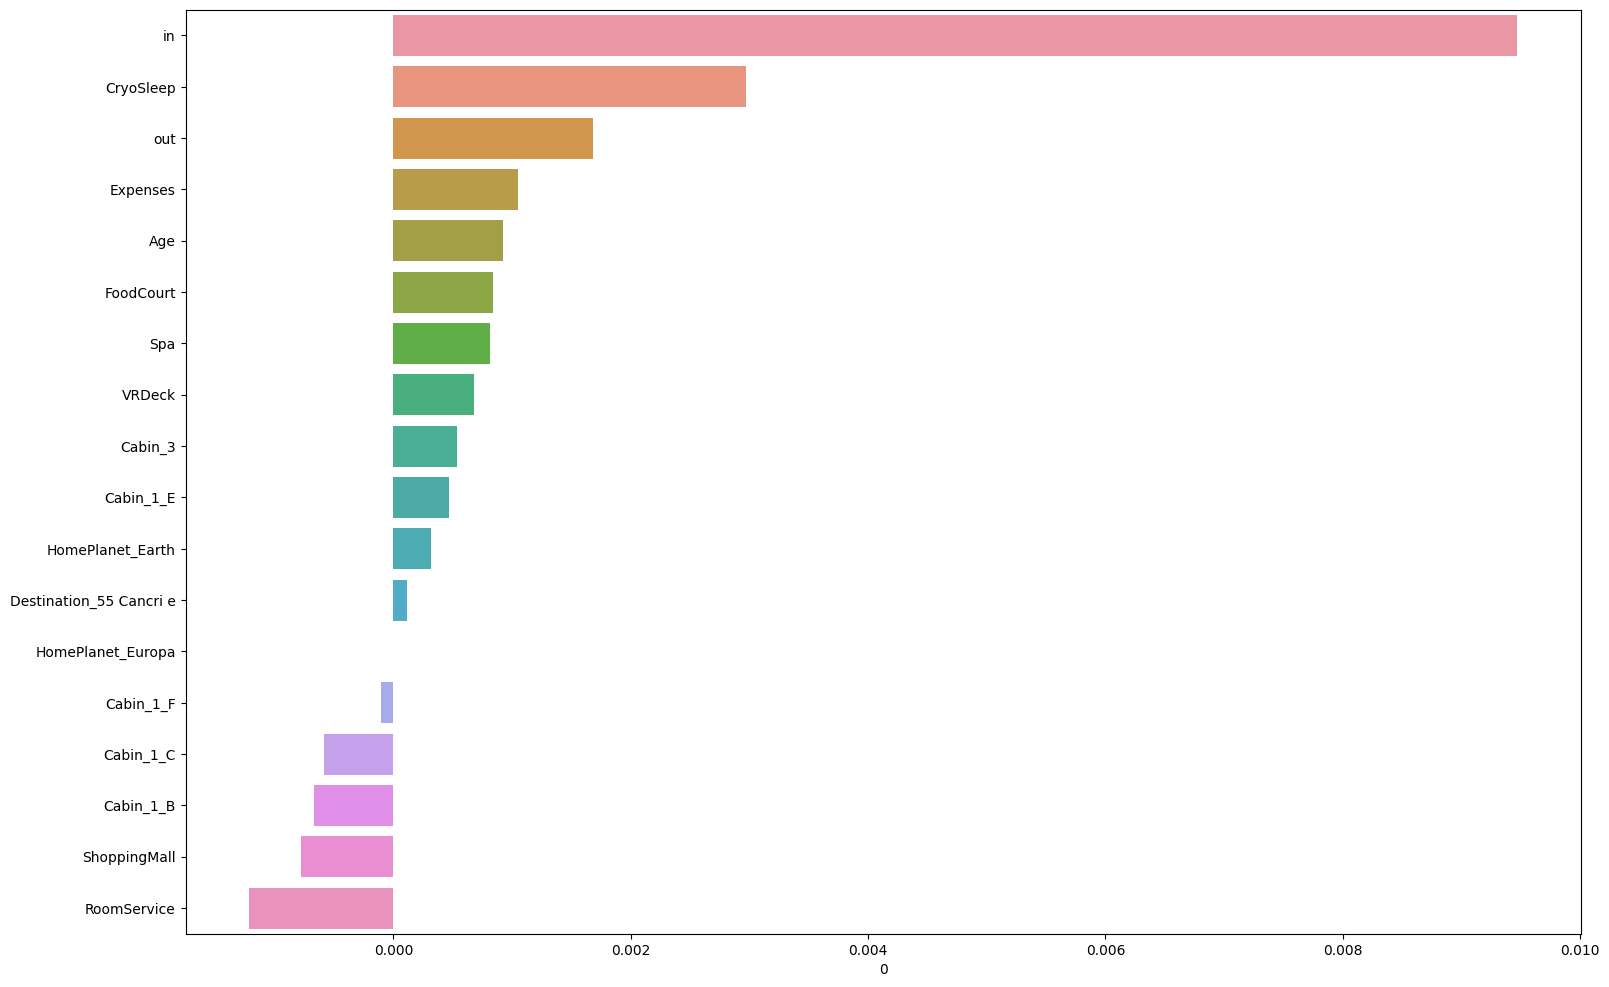

In [45]:
sozluk = {}
rf = RandomForestClassifier(n_estimators =300,random_state=0,max_depth=5)
score1=cross_val_score(rf,X_train,y_train,cv=10,n_jobs=-1,scoring="roc_auc").mean()

for col in X_train.columns:
    X_t2 = X_train.drop(col,axis=1)
    score = cross_val_score(rf,X_t2,y_train,cv=10,n_jobs=-1,scoring="roc_auc").mean()
    sozluk[col] = score1-score
    
seri = pd.Series(sozluk)
seri = pd.DataFrame(seri)
seri=seri.sort_values(by=0,ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(18,12))
sns.barplot(y=seri.index,x=seri[0])

In [46]:
train.columns

Index(['ShoppingMall', 'FoodCourt', 'RoomService', 'Spa', 'VRDeck', 'Expenses',
       'Age', 'in', 'out', 'CryoSleep', 'Cabin_1_B', 'Cabin_1_F', 'Cabin_1_E',
       'Cabin_1_C', 'Cabin_3', 'HomePlanet_Europa', 'HomePlanet_Earth',
       'Destination_55 Cancri e', 'Transported'],
      dtype='object')

In [47]:
train.drop(['ShoppingMall','RoomService','Destination_55 Cancri e'],axis=1,inplace=True)

In [48]:
X = train.drop("Transported",axis=1)
y=train["Transported"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [225]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
xg= XGBClassifier(n_estimators=400,max_depth=5,random_state=0)
sbs = SFS(estimator=xg, 
           k_features=10, 
           forward=False, 
           floating=True, 
           verbose=0,
           scoring='accuracy',
           cv=20,
           n_jobs=-1)

sbs = sbs.fit(X, y)

pd.DataFrame.from_dict(sbs.get_metric_dict()).T.sort_values('avg_score',ascending=False)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
17,"(1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0.8045977011494253, 0.7839080459770115, 0.777...",0.804217,"(FoodCourt, RoomService, VRDeck, Expenses, Age...",0.00916,0.019141,0.004391
14,"(1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 18)","[0.8045977011494253, 0.7839080459770115, 0.772...",0.803063,"(FoodCourt, RoomService, VRDeck, Expenses, Age...",0.010329,0.021585,0.004952
15,"(1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0.8068965517241379, 0.8, 0.7609195402298851, ...",0.802718,"(FoodCourt, RoomService, VRDeck, Expenses, Age...",0.009767,0.02041,0.004682
11,"(1, 4, 5, 6, 7, 9, 10, 12, 13, 14, 18)","[0.8022988505747126, 0.7908045977011494, 0.779...",0.802488,"(FoodCourt, VRDeck, Expenses, Age, in, CryoSle...",0.009071,0.018955,0.004349
13,"(0, 1, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 18)","[0.8091954022988506, 0.8068965517241379, 0.790...",0.80237,"(ShoppingMall, FoodCourt, VRDeck, Expenses, Ag...",0.008153,0.017037,0.003909
12,"(1, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 18)","[0.8068965517241379, 0.8137931034482758, 0.763...",0.802258,"(FoodCourt, VRDeck, Expenses, Age, in, CryoSle...",0.009288,0.019408,0.004453
16,"(1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0.8137931034482758, 0.8022988505747126, 0.760...",0.802144,"(FoodCourt, RoomService, VRDeck, Expenses, Age...",0.01046,0.021857,0.005014
18,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7954022988505747, 0.8, 0.7770114942528735, ...",0.801798,"(ShoppingMall, FoodCourt, RoomService, Spa, VR...",0.010625,0.022203,0.005094
10,"(1, 4, 5, 7, 9, 10, 12, 13, 14, 18)","[0.8, 0.8045977011494253, 0.7609195402298851, ...",0.800416,"(FoodCourt, VRDeck, Expenses, in, CryoSleep, C...",0.010286,0.021494,0.004931
19,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.8022988505747126, 0.8022988505747126, 0.786...",0.799036,"(ShoppingMall, FoodCourt, RoomService, Spa, VR...",0.00859,0.01795,0.004118


In [226]:
pd.DataFrame.from_dict(sbs.get_metric_dict()).T.sort_values('avg_score',ascending=False)["feature_idx"].loc[17]

(1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18)

In [245]:
x2=X.iloc[:,[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]]

In [ ]:
x2

In [212]:
# X[['Expenses', 'in', 'out', 'CryoSleep', 'Cabin_1_F', 'Cabin_1_E', 'Cabin_1_C', 'Cabin_3', 'HomePlanet_Europa', 'HomePlanet_Earth']]

,Expenses,in,out,CryoSleep,Cabin_1_F,Cabin_1_E,Cabin_1_C,Cabin_3,HomePlanet_Europa,HomePlanet_Earth
0,0.0,0.0,0.0,0,0,0,0,1,1,0
1,736.0,702.0,34.0,0,1,0,0,2,0,1
2,10383.0,6807.0,3576.0,0,0,0,0,2,1,0
3,5176.0,3522.0,1654.0,0,0,0,0,2,1,0
4,1091.0,870.0,221.0,0,1,0,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...
8688,8536.0,1717.0,6819.0,0,0,0,0,1,1,0
8689,0.0,0.0,0.0,1,0,0,0,2,0,1
8690,1873.0,1.0,1872.0,0,0,0,0,2,0,1
8691,4637.0,3588.0,1049.0,0,0,1,0,2,1,0


In [ ]:
ctb = CatBoostClassifier(n_estimators=500,verbose=False,depth=5)

In [244]:
cross_val_score(ctb,x2,y,cv=20,scoring="accuracy",n_jobs=-1).mean()

0.8135311722019175

In [55]:
pd.crosstab(X.Cabin_1_B,y)

Transported,0,1
Cabin_1_B,,
0,4102,3795
1,213,583


In [57]:
pd.crosstab(X.Cabin_1_E,y)

Transported,0,1
Cabin_1_E,,
0,3749,4059
1,566,319


In [73]:
pd.crosstab(X.Cabin_1_F,y)

Transported,0,1
Cabin_1_F,,
0,2684,3099
1,1631,1279


In [ ]:
def objective(trial):
    
    param = { 
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'lambda': trial.suggest_float('lambda', 0, 10.0),
        'alpha': trial.suggest_float('alpha', 0, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1.0),
        'subsample': trial.suggest_float('subsample', 0.2,1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
        'n_estimators': trial.suggest_int('n_estimators', 400,1200),
        'max_depth': trial.suggest_categorical('max_depth', [2,3,4,5,6,7,8,9,10]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        
        }
    
    xgb = XGBClassifier(**param,tree_method='gpu_hist', gpu_id=0
        )

    score = cross_val_score(xgb, x2, y, n_jobs=-1, cv=20,scoring="accuracy")
    roc_auc = score.mean()
    return roc_auc

study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                direction='maximize')
study.optimize(objective, n_trials=70)

In [247]:
trial = study.best_trial
print(trial.value)
print(trial.params)

0.8115790031251654
{'lambda': 3.4134476471950705, 'alpha': 6.108126112687961, 'colsample_bytree': 0.8898225464083783, 'subsample': 0.9813129870138768, 'learning_rate': 0.024674520534706174, 'n_estimators': 526, 'max_depth': 9, 'min_child_weight': 1}


In [249]:
xgb = XGBClassifier(**trial.params)
cross_val_score(xgb, X, y, n_jobs=-1, cv=20,scoring="roc_auc").mean()

0.8940011665058467